In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

import os

import warnings
warnings.filterwarnings("ignore")


df=pd.read_csv(r'C:\Users\isarachchand\\Documents\git\apf\datasets\cyber_risk\data\malign_websites_dataset.csv')

In [2]:
#Prep the data

100 * df['Type'].value_counts()/len(df)   #variable imbalance

#unique categories for each categorical column

for i in df.select_dtypes(include='object').columns:
    print(f"{i} -> {df[i].nunique()}")
    
df['CHARSET'].value_counts()

# Top 5 categories kept

def CHARSET_CLEANER(x):
    if x not in ['UTF-8','ISO-8859-1','utf-8','us-ascii','iso-8859-1']:
        return "OTHERS"
    else:
        return x

df['CHARSET'] = df['CHARSET'].apply(CHARSET_CLEANER)
df['CHARSET'].value_counts()
df['SERVER'].value_counts()

# Top 5 categories kept

def SERVER_CLEANER(x):
    if x not in ['Apache','nginx','None','Microsoft-HTTPAPI/2.0','cloudflare-nginx']:
        return "OTHERS"
    else:
        return x
    
df['SERVER'] = df['SERVER'].apply(SERVER_CLEANER)
df['SERVER'].value_counts()
df['WHOIS_STATEPRO'].value_counts()[:11]

def STATE_CLEANER(x):
    if x not in ['CA','None','NY','WA','Barcelona','FL']:
        return "OTHERS"
    else:
        return x

df['WHOIS_STATEPRO'] = df['WHOIS_STATEPRO'].apply(STATE_CLEANER)
df['WHOIS_STATEPRO'].value_counts()

def DATE_CLEANER(x):
    if x == 'None':
        return "Absent"
    else:
        return "Present"
df['WHOIS_REGDATE'] = df['WHOIS_REGDATE'].apply(DATE_CLEANER)
df['WHOIS_UPDATED_DATE'] = df['WHOIS_UPDATED_DATE'].apply(DATE_CLEANER)

df.drop(['URL','WHOIS_COUNTRY','CONTENT_LENGTH'],axis=1,inplace=True)
# change null values to 0

df = df.fillna(0)

le = LabelEncoder()
for column in ['CHARSET','SERVER', 'WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']:
    df[column] = le.fit_transform(df[column].astype(str))



URL -> 1781
CHARSET -> 9
SERVER -> 239
WHOIS_COUNTRY -> 49
WHOIS_STATEPRO -> 182
WHOIS_REGDATE -> 891
WHOIS_UPDATED_DATE -> 594


In [3]:
# Split data
y = df['Type']
X = df.drop('Type', axis=1)

best_index = 1
partition_count = 5

# get train test split
partition_size = math.ceil(len(X) / partition_count)
test_start = best_index * partition_size
test_end = test_start + partition_size
test_x = X[test_start:test_end]
test_y = y[test_start:test_end]
train_x = pd.concat([X[:test_start],X[test_end:]])
train_y =  pd.concat([y[:test_start], y[test_end:]])

## Hyperparameter Optimisation with Random Forest

In [29]:
space={'max_depth': hp.quniform("max_depth", 10, 180, 1), # 120, 180
        'min_sample_leaf' : hp.uniform('min_samples_leaf',1,5),
        'min_samples_split':hp.uniform('min_samples_split',2,6),
        'n_estimators': hp.uniform('n_estimators', 200, 900), # 100, 200, 300
       'max_features':hp.choice('max_features',['sqrt', 'log2'])
    }

def objective(space):
    
    clf = RandomForestClassifier(
        n_estimators=int(space['n_estimators']), max_depth=int(space['max_depth']),
        min_samples_split=int(space['min_samples_split']),
        min_samples_leaf=int(space['min_sample_leaf']),
        max_features=space['max_features'], random_state=2)

    clf.fit(train_x, train_y)
    pred = clf.predict(test_x)

    accuracy = recall_score(test_y, pred, average='macro')
    
    print("Accuracy: ", accuracy)
    print("\n")
    return {'loss': -accuracy, 'status': STATUS_OK}


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

print("Best hyperparameters are: {}".format(best_hyperparams))

Accuracy:                                              
0.8017134918184625                                     
Accuracy:                                                                         
0.8017134918184625                                                                
Accuracy:                                                                         
0.8017134918184625                                                                
Accuracy:                                                                         
0.8017134918184625                                                                
Accuracy:                                                                         
0.8017134918184625                                                                
Accuracy:                                                                         
0.8017134918184625                                                                
Accuracy:                                                 

0.789518369867243                                                                  
Accuracy:                                                                          
0.8017134918184625                                                                 
Accuracy:                                                                          
0.8017134918184625                                                                 
Accuracy:                                                                           
0.789518369867243                                                                   
Accuracy:                                                                           
0.8017134918184625                                                                  
Accuracy:                                                                           
0.8032957702994752                                                                  
Accuracy:                                                             

0.8032957702994752                                                                  
Accuracy:                                                                           
0.8017134918184625                                                                  
Accuracy:                                                                           
0.8017134918184625                                                                  
Accuracy:                                                                           
0.789518369867243                                                                   
Accuracy:                                                                           
0.7911006483482557                                                                  
Accuracy:                                                                           
0.8032957702994752                                                                  
Accuracy:                                                        

In [24]:
for t in trials.trials[:2]:
    print (t)

{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': -0.8032957702994752, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'max_depth': [0], 'max_features': [0], 'min_samples_leaf': [0], 'min_samples_split': [0], 'n_estimators': [0]}, 'vals': {'max_depth': [21.0], 'max_features': [1], 'min_samples_leaf': [1.519065310393377], 'min_samples_split': [4.787024485899021], 'n_estimators': [234.39981229435685]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2022, 6, 14, 9, 46, 11, 357000), 'refresh_time': datetime.datetime(2022, 6, 14, 9, 46, 12, 485000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': -0.8017134918184625, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'max_depth': [1], 'max_features': [1], 'min_samples_leaf': [1], 'min_samples_split': [1], 'n_estimators': [1]}, 'vals': {'max_depth': [103.0], 'max_features': [0

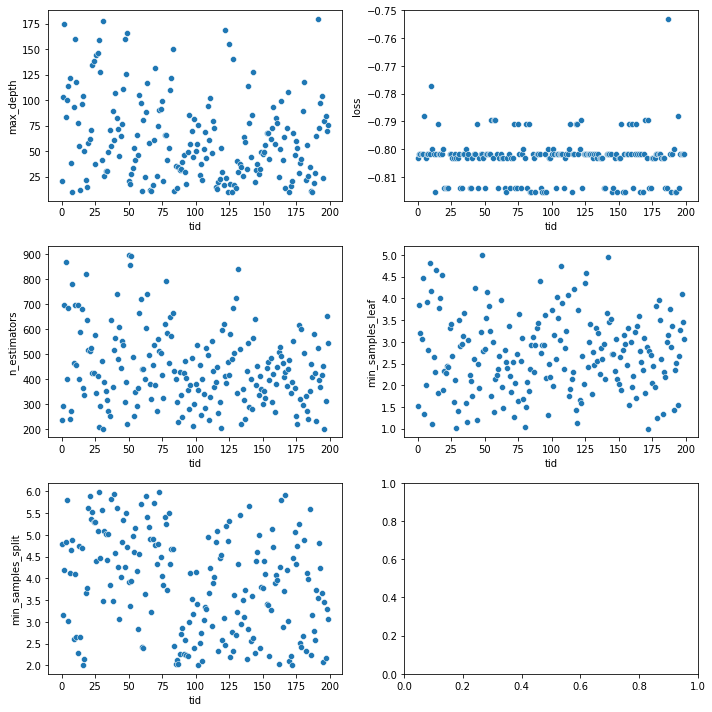

In [25]:
TID=[t['tid'] for t in trials.trials]
Loss=[t['result']['loss'] for t in trials.trials]
maxd=[t['misc']['vals']['max_depth'][0] for t in trials.trials]
nest=[t['misc']['vals']['n_estimators'][0] for t in trials.trials]
min_ss=[t['misc']['vals']['min_samples_split'][0] for t in trials.trials]
min_sl=[t['misc']['vals']['min_samples_leaf'][0] for t in trials.trials]

hyperopt_rfr=pd.DataFrame({'tid':TID,'loss':Loss,
                          'max_depth':maxd,'n_estimators':nest,
                          'min_samples_split':min_ss, 'min_samples_leaf':min_sl})

plt.subplots(3,2,figsize=(10,10))
plt.subplot(3,2,1)
sns.scatterplot(x='tid',y='max_depth',data=hyperopt_rfr)
plt.subplot(3,2,2)
sns.scatterplot(x='tid',y='loss',data=hyperopt_rfr)
plt.subplot(3,2,3)
sns.scatterplot(x='tid',y='n_estimators',data=hyperopt_rfr)
plt.subplot(3,2,4)
sns.scatterplot(x='tid',y='min_samples_leaf',data=hyperopt_rfr)
plt.subplot(3,2,5)
sns.scatterplot(x='tid',y='min_samples_split',data=hyperopt_rfr)

plt.tight_layout()



In [26]:
# create model with best parameters

#create classifier 
clf = RandomForestClassifier(n_estimators=int(best_hyperparams['n_estimators']), max_depth=int(best_hyperparams['max_depth']), min_samples_split=int(best_hyperparams['min_samples_split']), min_samples_leaf=int(best_hyperparams['min_samples_leaf']), random_state=2)

clf.fit(train_x, train_y)
predictions = clf.predict(test_x)

rf_accuracy_score = accuracy_score(predictions, test_y)
recall_accuracy = recall_score(test_y, predictions, average='macro')

print("Accuracy Score", rf_accuracy_score)
print("Recall Score", recall_accuracy)



Accuracy Score 0.9551820728291317
Recall Score 0.8154908922506947


## Hyperparameter optimisation XGBClassifier

In [27]:
space2={'max_depth': hp.quniform("max_depth", 10, 180, 1), # 120, 180
        'gamma': hp.uniform ('gamma', 1,25),
        #'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        #'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        #'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        #'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.uniform('n_estimators', 200, 900), # 100, 200, 300
        #"n_estimators": hp.quniform('n_estimators', 100,200,1),
        #'seed': 0
    }


def objective2(space2):
    clf_model = xgb.XGBClassifier(
        n_estimators=int(space2['n_estimators']), gamma=space2['gamma'], max_depth=int(space2['max_depth']), random_state=2)

    print(int(space2['n_estimators']))
    print(int(space2['max_depth']))

    evaluation = [(train_x, train_y), (test_x, test_y)]

    clf_model.fit(train_x, train_y,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10, verbose=False)

    pred2 = clf_model.predict(test_x)
    #accuracy = accuracy_score(y_test, pred)
    accuracy2 = recall_score(test_y, pred2, average='macro')

    print("SCORE:", accuracy2)
    return {'loss': -accuracy2, 'status': STATUS_OK}


trials2 = Trials()

best_hyperparams2 = fmin(fn = objective2,
                        space = space2,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials2)

print("The best hyperparameters are : ","\n")
print(best_hyperparams2)

456                                                    
87                                                     
SCORE:                                                 
0.7041525162087063                                     
766                                                    
124                                                                               
SCORE:                                                                            
0.8457471441803026                                                                
856                                                                               
115                                                                               
SCORE:                                                                            
0.8579422661315221                                                                
540                                                                               
35                                                      

730                                                                                
11                                                                                 
SCORE:                                                                             
0.7041525162087063                                                                 
380                                                                                
128                                                                                
SCORE:                                                                             
0.8489117011423278                                                                 
824                                                                                
143                                                                                
SCORE:                                                                             
0.7163476381599259                                                          

SCORE:                                                                             
0.86268910157456                                                                   
754                                                                                
88                                                                                 
SCORE:                                                                             
0.7163476381599259                                                                 
712                                                                                
111                                                                                
SCORE:                                                                             
0.7163476381599259                                                                 
100%|██████████| 100/100 [00:16<00:00,  6.22trial/s, best loss: -0.8733019450447669]
The best hyperparameters are :  

{'gamma': 5.574600311758998, 'max_depth':

In [28]:
# create model with best parameters

#create classifier 
best_model = xgb.XGBClassifier(n_estimators=int(best_hyperparams2['n_estimators']), gamma=best_hyperparams2['gamma'], max_depth=int(best_hyperparams2['max_depth']), random_state=2)

best_model.fit(train_x, train_y)
predictions2 = best_model.predict(test_x)

rf_accuracy_score2 = accuracy_score(predictions2, test_y)
recall_accuracy2 = recall_score(test_y, predictions2, average='macro')

print("Accuracy Score", rf_accuracy_score2)
print("Recall Score", recall_accuracy2)

Accuracy Score 0.957983193277311
Recall Score 0.8382988576721211
